In [18]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

permittivity_real = np.random.uniform(0, 10, 20000)
permittivity_imaginary = np.random.uniform(0, 0.1, 20000)
orientation = np.random.randint(1, 20, 20000) 
data = {
    'Frequency': np.linspace(1.0, 4.0, 20000),
    'Orientation':orientation,
    'S11 Real': np.random.uniform(-0.01, 0.02, 20000),
    'S11 Imaginary': np.random.uniform(0, 0.06, 20000),
    'S12 Real': np.random.uniform(-0.01, 0.02, 20000),
    'S12 Imaginary': np.random.uniform(0, 0.06, 20000),
    'S21 Real': np.random.uniform(-0.01, 0.02, 20000),
    'S21 Imaginary': np.random.uniform(0, 0.06, 20000),
    'S22 Real': np.random.uniform(-0.01, 0.02, 20000),
    'S22 Imaginary': np.random.uniform(0, 0.06, 20000),
    'Permittivity Real': permittivity_real,
    'Permittivity Imaginary': permittivity_imaginary
}
df = pd.DataFrame(data)
print(f"Output: {permittivity_real}")
print(f"Output: {permittivity_imaginary}")
print(f"Dataframe: ")
print(df)

Output: [0.74671415 0.90332903 0.08042305 ... 5.91457902 2.389537   3.41686978]
Output: [0.07011405 0.04409416 0.04059555 ... 0.06154627 0.02334183 0.03312671]
Dataframe: 
       Frequency  Orientation  S11 Real  S11 Imaginary  S12 Real   
0        1.00000            1 -0.006868       0.058591  0.019214  \
1        1.00015            8  0.003320       0.050629  0.009582   
2        1.00030            2  0.018906       0.004581  0.009058   
3        1.00045           19 -0.006167       0.019530 -0.005299   
4        1.00060            9  0.011448       0.038435  0.015217   
...          ...          ...       ...            ...       ...   
19995    3.99940            2 -0.000937       0.047967 -0.007414   
19996    3.99955           15 -0.003095       0.025507 -0.006954   
19997    3.99970            4 -0.005439       0.053296  0.017834   
19998    3.99985            3  0.000239       0.059653  0.008985   
19999    4.00000            9 -0.003984       0.007796  0.019908   

       S12 

In [19]:
df

,Frequency,Orientation,S11 Real,S11 Imaginary,S12 Real,S12 Imaginary,S21 Real,S21 Imaginary,S22 Real,S22 Imaginary,Permittivity Real,Permittivity Imaginary
0,1.00000,1,-0.006868,0.058591,0.019214,0.013242,0.003588,0.048713,-0.003488,0.017862,0.746714,0.070114
1,1.00015,8,0.003320,0.050629,0.009582,0.047376,0.002693,0.003574,0.003287,0.020290,0.903329,0.044094
2,1.00030,2,0.018906,0.004581,0.009058,0.025828,0.018817,0.033542,0.008668,0.059787,0.080423,0.040596
3,1.00045,19,-0.006167,0.019530,-0.005299,0.015117,0.019048,0.011355,0.005638,0.057393,3.645529,0.051176
4,1.00060,9,0.011448,0.038435,0.015217,0.040102,-0.005671,0.055063,0.014173,0.044304,6.125135,0.094584
...,...,...,...,...,...,...,...,...,...,...,...,...
19995,3.99940,2,-0.000937,0.047967,-0.007414,0.033600,0.016568,0.042851,0.012115,0.042026,6.229298,0.086582
19996,3.99955,15,-0.003095,0.025507,-0.006954,0.034206,0.012760,0.048077,0.007367,0.002332,0.405627,0.081276
19997,3.99970,4,-0.005439,0.053296,0.017834,0.055087,0.006825,0.055705,0.009790,0.011020,5.914579,0.061546
19998,3.99985,3,0.000239,0.059653,0.008985,0.018176,0.002233,0.004129,0.010495,0.039086,2.389537,0.023342


In [20]:
df.columns = ['frequency','orientation','s11_real','s11_imaginary','s12_real','s12_imaginary','s21_real','s21_imaginary','s22_real','s22_imaginary','permittivity_real','permittivity_imaginary']

In [21]:
from sklearn.preprocessing import MinMaxScaler
X_norm = MinMaxScaler().fit(df[['s11_real','s11_imaginary','s12_real','s12_imaginary','s21_real','s21_imaginary','s22_real','s22_imaginary','permittivity_real','permittivity_imaginary']])
df[['s11_real','s11_imaginary','s12_real','s12_imaginary','s21_real','s21_imaginary','s22_real','s22_imaginary','permittivity_real','permittivity_imaginary']] =  X_norm.transform(df[['s11_real','s11_imaginary','s12_real','s12_imaginary','s21_real','s21_imaginary','s22_real','s22_imaginary','permittivity_real','permittivity_imaginary']])

In [22]:
df['orientation'] = df['orientation'].astype('category')
df = pd.get_dummies(df, columns=['orientation'])

In [23]:
c = []
for i in df.columns:
    if i != permittivity_real or i !=permittivity_imaginary:
        c.append(i)

/var/folders/lk/g6q_4n912156v7109ds7l5mm0000gn/T/ipykernel_43154/1338281437.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if i != permittivity_real or i !=permittivity_imaginary:


In [24]:
df_original = df.copy()

In [25]:
X = df[c].values
y = df[['permittivity_real','permittivity_imaginary']].values

In [26]:
indices = np.random.permutation(len(X))
X = X[indices]
y = y[indices]
split_point = int(0.8 * len(X))
X_train = X[:split_point]
y_train = y[:split_point]
X_val = X[split_point:]
y_val = y[split_point:]

In [27]:
X_train.shape

(16000, 30)

In [28]:
y_train.shape

(16000, 2)

In [29]:
X_val.shape

(4000, 30)

In [30]:
y_val.shape

(4000, 2)

In [31]:
def mae_loss(y_true, y_pred):
    y_true_real, y_true_imag = tf.split(y_true, 2, axis=-1)
    y_pred_real, y_pred_imag = tf.split(y_pred, 2, axis=-1)
    loss_real = tf.losses.mean_absolute_error(y_true_real, y_pred_real)
    loss_imag = tf.losses.mean_absolute_error(y_true_imag, y_pred_imag)
    return loss_real + loss_imag
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(y.shape[1], activation='linear')
])
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001),
              loss=[mae_loss],
              metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError()])

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 128)               3968      
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 16)                528       
                                                                 
 dense_9 (Dense)             (None, 2)                 34        
                                                                 
Total params: 14866 (58.07 KB)
Trainable params: 14866 (58.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
X_train = X_train.astype(float)
y_train = y_train.astype(float)
X_val = X_val.astype(float)
y_val = y_val.astype(float)

Epoch 1/10


16000/16000 [==============================] - 9s 553us/step - loss: 0.0920 - mean_absolute_error: 0.0460 - mean_squared_error: 0.0103 - val_loss: 0.0365 - val_mean_absolute_error: 0.0182 - val_mean_squared_error: 5.0996e-04
Epoch 2/10
16000/16000 [==============================] - 9s 540us/step - loss: 0.0245 - mean_absolute_error: 0.0123 - mean_squared_error: 2.4670e-04 - val_loss: 0.0179 - val_mean_absolute_error: 0.0090 - val_mean_squared_error: 1.3601e-04
Epoch 3/10
16000/16000 [==============================] - 9s 534us/step - loss: 0.0185 - mean_absolute_error: 0.0093 - mean_squared_error: 1.4259e-04 - val_loss: 0.0133 - val_mean_absolute_error: 0.0067 - val_mean_squared_error: 7.2022e-05
Epoch 4/10
16000/16000 [==============================] - 9s 570us/step - loss: 0.0162 - mean_absolute_error: 0.0081 - mean_squared_error: 1.0816e-04 - val_loss: 0.0131 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 6.6638e-05
Epoch 5/10
16000/16000 [==============================]

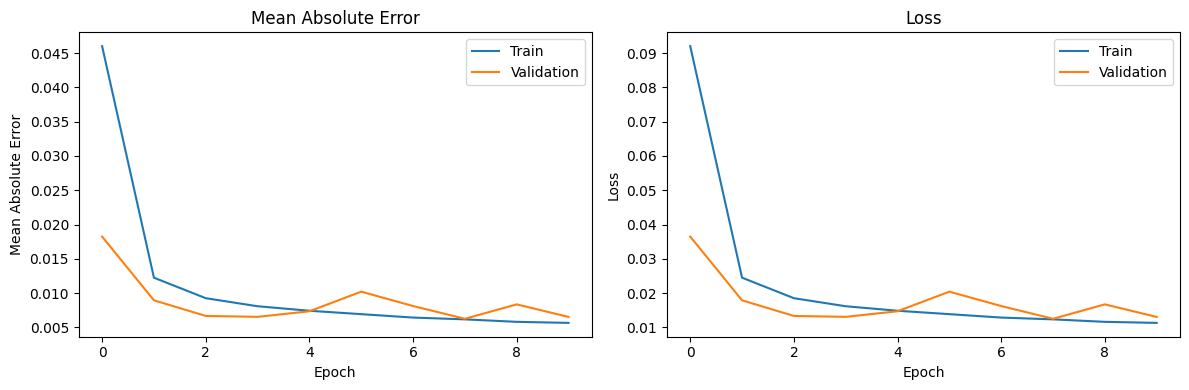

In [34]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=1)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend(['Train', 'Validation'])
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.tight_layout()
plt.show()


In [35]:
collapse_orientation = df_original[['orientation_1', 'orientation_2', 'orientation_3', 'orientation_4',
                                   'orientation_5', 'orientation_6', 'orientation_7', 'orientation_8',
                                   'orientation_9', 'orientation_10', 'orientation_11', 'orientation_12',
                                   'orientation_13', 'orientation_14', 'orientation_15', 'orientation_16',
                                   'orientation_17', 'orientation_18', 'orientation_19']].idxmax(axis=1)
collapse_orientation_int = collapse_orientation.str.extract(r'(\d+)').astype(int)
collapse_orientation_int.columns = ['orientation']


125/125 [==============================] - 0s 267us/step


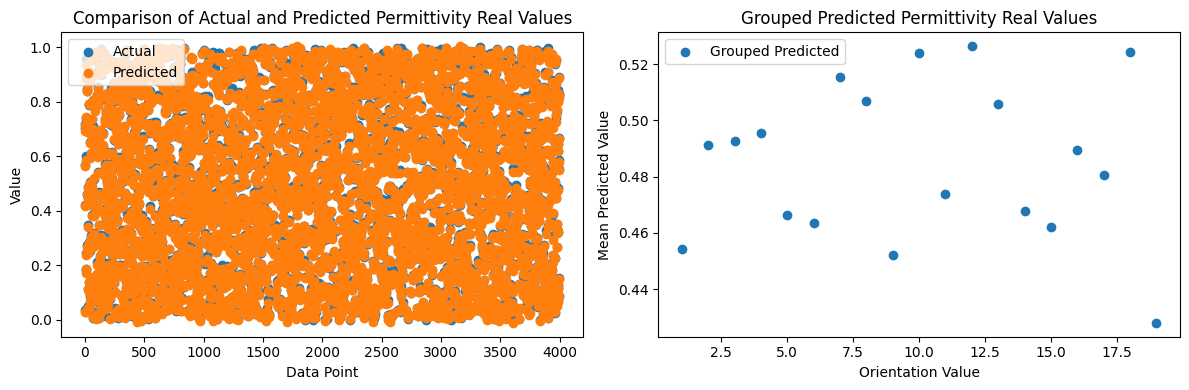

In [36]:
y_pred = model.predict(X_val)
df_predicted = pd.DataFrame({'orientation_value': collapse_orientation_int['orientation'][split_point:], 'y_pred': y_pred[:, 0]})
y_pred_grouped = df_predicted.groupby('orientation_value')['y_pred'].mean().reset_index()
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(range(len(y_val)), y_val[:, 0], label='Actual')
plt.scatter(range(len(y_pred)), y_pred[:, 0], label='Predicted')
plt.title('Comparison of Actual and Predicted Permittivity Real Values')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(y_pred_grouped['orientation_value'], y_pred_grouped['y_pred'], label='Grouped Predicted')
plt.title('Grouped Predicted Permittivity Real Values')
plt.xlabel('Orientation Value')
plt.ylabel('Mean Predicted Value')
plt.legend()
plt.tight_layout()
plt.show()


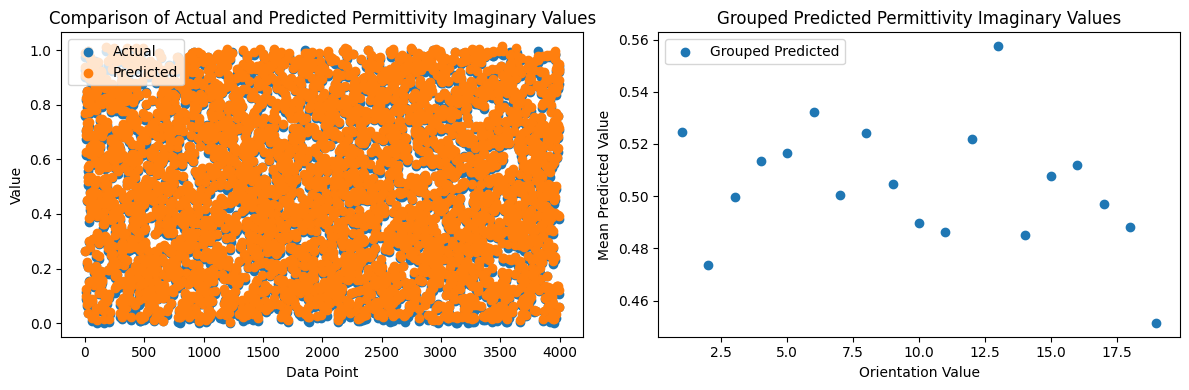

In [37]:
df_predicted = pd.DataFrame({'orientation_value': collapse_orientation_int['orientation'][split_point:], 'y_pred': y_pred[:, 1]})
y_pred_grouped = df_predicted.groupby('orientation_value')['y_pred'].mean().reset_index()
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(range(len(y_val)), y_val[:, 1], label='Actual')
plt.scatter(range(len(y_pred)), y_pred[:, 1], label='Predicted')
plt.title('Comparison of Actual and Predicted Permittivity Imaginary Values')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(y_pred_grouped['orientation_value'], y_pred_grouped['y_pred'], label='Grouped Predicted')
plt.title('Grouped Predicted Permittivity Imaginary Values')
plt.xlabel('Orientation Value')
plt.ylabel('Mean Predicted Value')
plt.legend()
plt.tight_layout()
plt.show()